### SHRED applied to ARA dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, which is hyperparameter tuned.

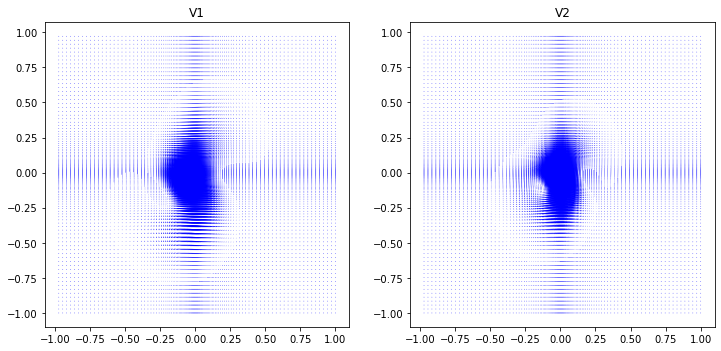

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#-----------
# Read Data
#-----------

# Open File
h5file = '/Users/nathankutz/ARAdata/simVectors010105.h5'
f = h5py.File(h5file)

# Read Grid/Time Vectors
t1 = f['t1']
t2 = f['t2']
x = f['x']
y = f['y']

# Get Sizes
nt = np.size(t1)
nx = np.size(x,0)
ny = np.size(y,0)

# Get Vectors
Vx1 = f['Vx1']
Vy1 = f['Vy1']
Vz1 = f['Vz1']

Vx2 = f['Vx2']
Vy2 = f['Vy2']
Vz2 = f['Vz2']

#-------------------------
# Create Animations/Plots
#-------------------------

#"""
# Create Single Frame Plot
fig = plt.figure(figsize =(12, 6))

it = 300
ax = fig.add_subplot(121)
ax.quiver(x,y,Vx1[:,:,it],Vy1[:,:,it], color='b', alpha=1)
ax.set_title('V1')
ax.set_aspect('equal')

ax = fig.add_subplot(122)
ax.quiver(x,y,Vx2[:,:,it],Vy2[:,:,it], color='b', alpha=1)
ax.set_title('V2')
ax.set_aspect('equal')

plt.show()



In [14]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

num_sensors = 3 
lags = 52
Vx1flat = np.reshape(Vx1, (119 * 119, 1786))
load_X = Vx1flat.T
#load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
load_X.shape

(1786, 14161)

We now select indices to divide the data into training, validation, and test sets.

In [15]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [16]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

We train the model using the training and validation datasets.

In [17]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.4719)
Training epoch 20
Error tensor(0.0968)
Training epoch 40
Error tensor(0.0661)
Training epoch 60
Error tensor(0.0522)
Training epoch 80
Error tensor(0.0511)
Training epoch 100
Error tensor(0.0545)
Training epoch 120
Error tensor(0.0436)
Training epoch 140
Error tensor(0.0428)
Training epoch 160
Error tensor(0.0502)
Training epoch 180
Error tensor(0.0429)
Training epoch 200
Error tensor(0.0417)
Training epoch 220
Error tensor(0.0399)
Training epoch 240
Error tensor(0.0398)
Training epoch 260
Error tensor(0.0403)
Training epoch 280
Error tensor(0.0415)
Training epoch 300
Error tensor(0.0399)
Training epoch 320
Error tensor(0.0366)
Training epoch 340
Error tensor(0.0370)
Training epoch 360
Error tensor(0.0407)
Training epoch 380
Error tensor(0.0389)
Training epoch 400
Error tensor(0.0321)
Training epoch 420
Error tensor(0.0324)
Training epoch 440
Error tensor(0.0438)
Training epoch 460
Error tensor(0.0329)
Training epoch 480
Error tensor(0.0416)
Traini

Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [18]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.043678466


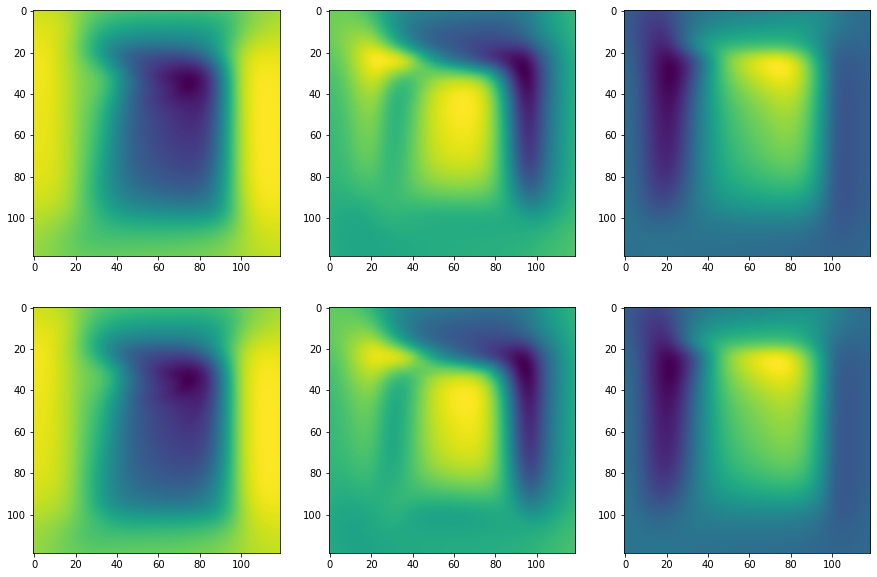

In [26]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 3, 1)
plt.imshow(test_recons[100].reshape(119,119))
ax = fig.add_subplot(2, 3, 4)
plt.imshow(test_ground_truth[100].reshape(119,119))
ax = fig.add_subplot(2, 3, 2)
plt.imshow(test_recons[200].reshape(119,119))
ax = fig.add_subplot(2, 3, 5)
plt.imshow(test_ground_truth[200].reshape(119,119))
ax = fig.add_subplot(2, 3, 3)
plt.imshow(test_recons[350].reshape(119,119))
ax = fig.add_subplot(2, 3, 6)
plt.imshow(test_ground_truth[350].reshape(119,119))


